In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.optimize as opt
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#sns.set_style("dark")
#sns.set(font_scale=1.6)

Воспользуемся алгоритмом CAMNS-LP, описанным в статье:

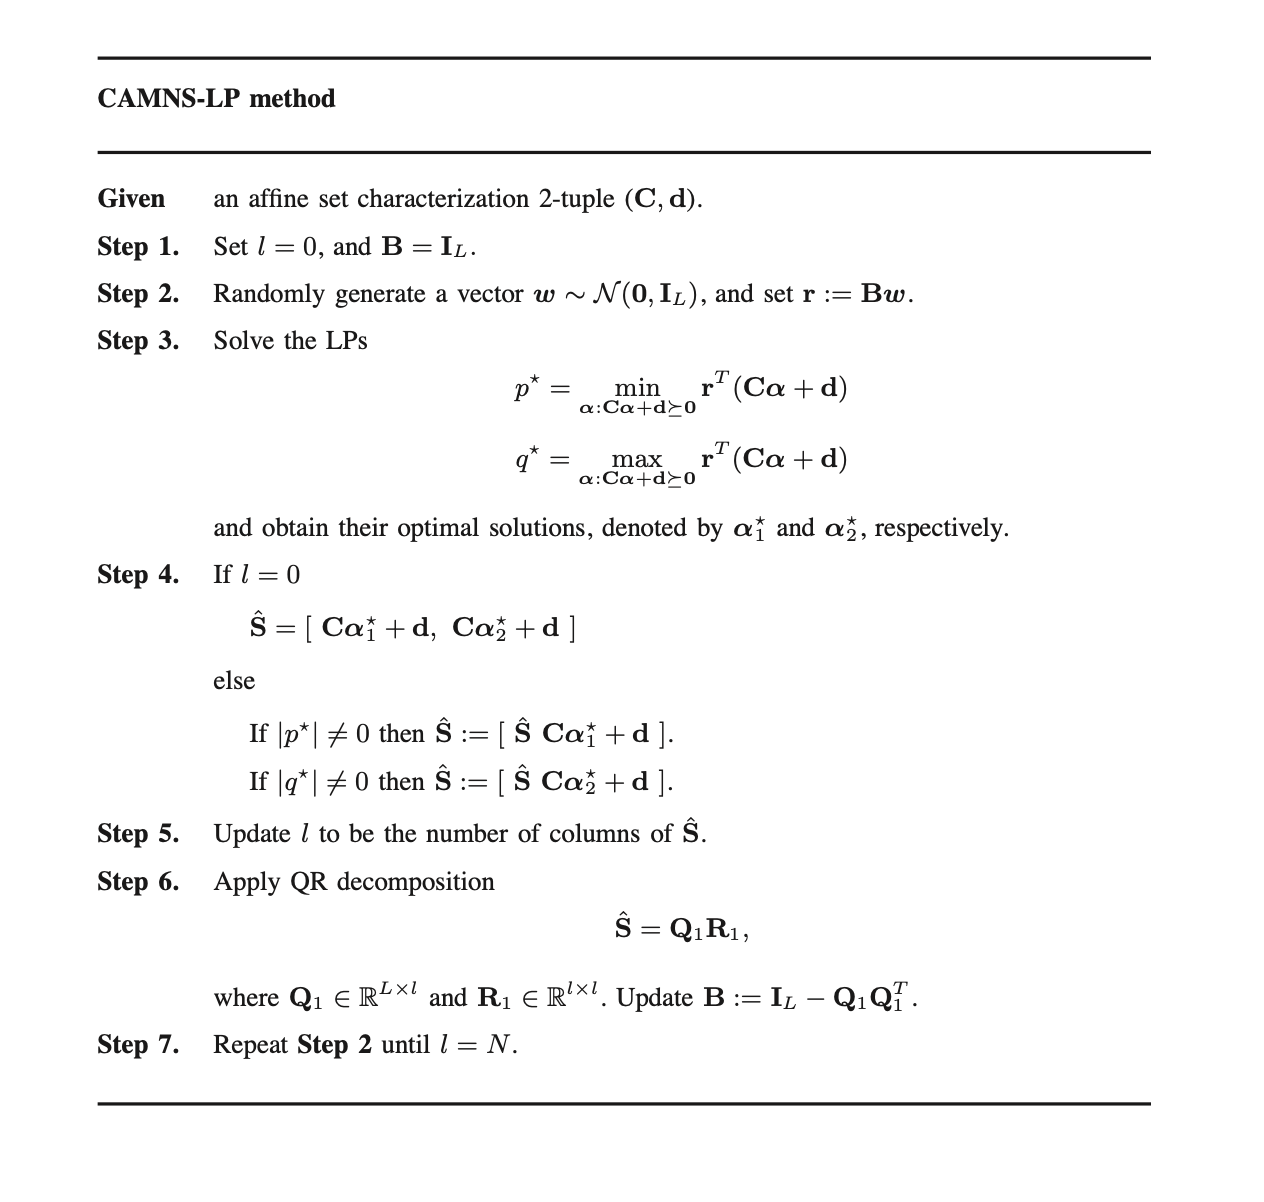

Поиск параметров C и d будем также проводить по предложенному алгоритму:

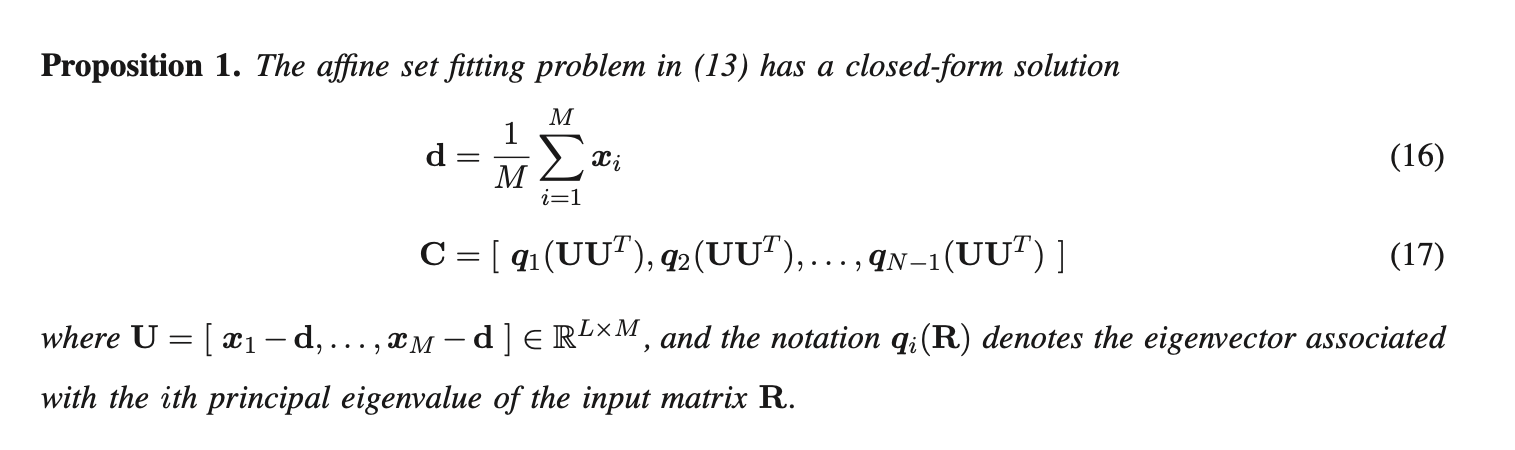

In [2]:
def get_hyperplane(X):
    N, _ = X.shape
    d = X.mean(axis=0)
    U = (X - d).T
    return U[:, :N-1], d


def CAMNS_LP(X):
    C, d = get_hyperplane(X)
    N, L = X.shape
    l = 0
    B = np.eye(L)
    
    vec_inf = np.ones(d.shape[0]) * np.inf
    
    while l < N:
        w = sps.norm().rvs(L)
        r = B @ w
        
        def func(a):
            return r.T @ (C @ a + d)
        
        def func_max(a):
            return -func(a)
        
        a1 = opt.minimize(
            fun=func,
            constraints=opt.LinearConstraint(
                A=C,
                lb=-d,
                ub=vec_inf
            ),
            x0=np.zeros(N - 1)
        ).x
        
        a2 = opt.minimize(
            fun=func_max,
            constraints=opt.LinearConstraint(
                A=C,
                lb=-d,
                ub=vec_inf
            ),
            x0=np.zeros(N - 1)
        ).x
        
        p = func(a1)
        q = func(a2)
        
        if l == 0:
            S = np.array([C @ a1 + d, C @ a2 + d]).T
        else:
            if np.linalg.norm(p) != 0:
                new_vector = C @ a1 + d
            else:
                new_vector = C @ a2 + d
            S = np.hstack([S, new_vector.reshape(-1, 1)])
        
        l = S.shape[1]
        
        Q, R = np.linalg.qr(S)
        B = np.eye(L) - Q @ Q.T
        
    return S.T

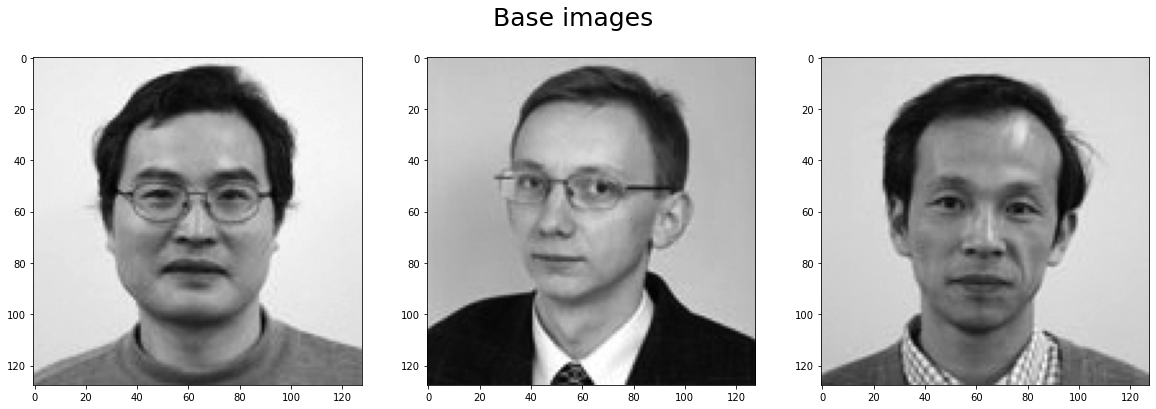

In [3]:
path1 = ['./photo/cao1.jpg', './photo/ksiwek1.jpg', './photo/zhang1.jpg']
img1 = [plt.imread(path) for path in path1]

img_shape = img1[0].shape

plt.figure(figsize=(20, 10))
for i, img in enumerate(img1):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    
plt.suptitle("Base images", y=0.8, fontsize=25)
plt.show()

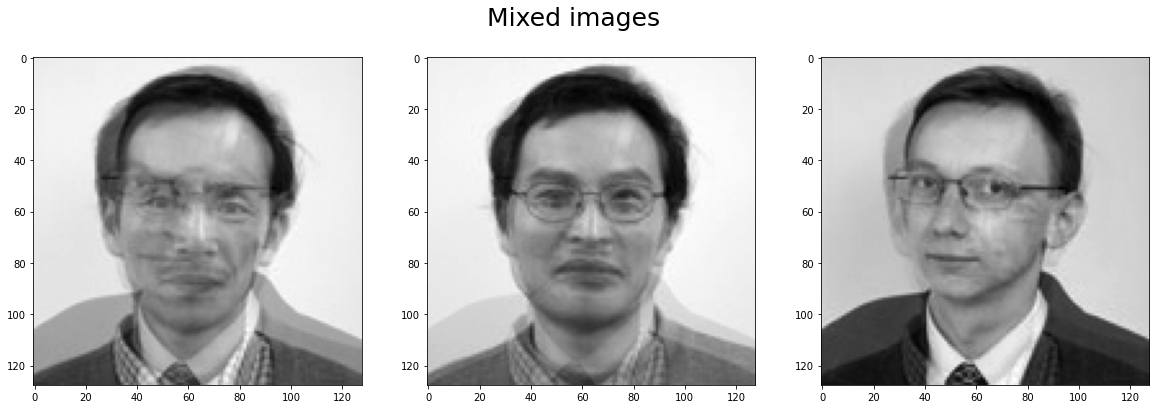

In [17]:
s_values = np.array([img.flatten() for img in img1])

coeff = np.array([
    [0.2, 0.3, 0.5],
    [0.6, 0.1, 0.3],
    [0.1, 0.7, 0.2]
])

x_values = coeff @ s_values

plt.figure(figsize=(20, 10))
for i in range(3):
    new_img = x_values[i, :].reshape(img_shape)
    plt.subplot(1, 3, i + 1)
    plt.imshow(new_img, cmap='gray')
    
plt.suptitle("Mixed images", y=0.8, fontsize=25)
plt.show()

In [18]:
base_img = CAMNS_LP(x_values)

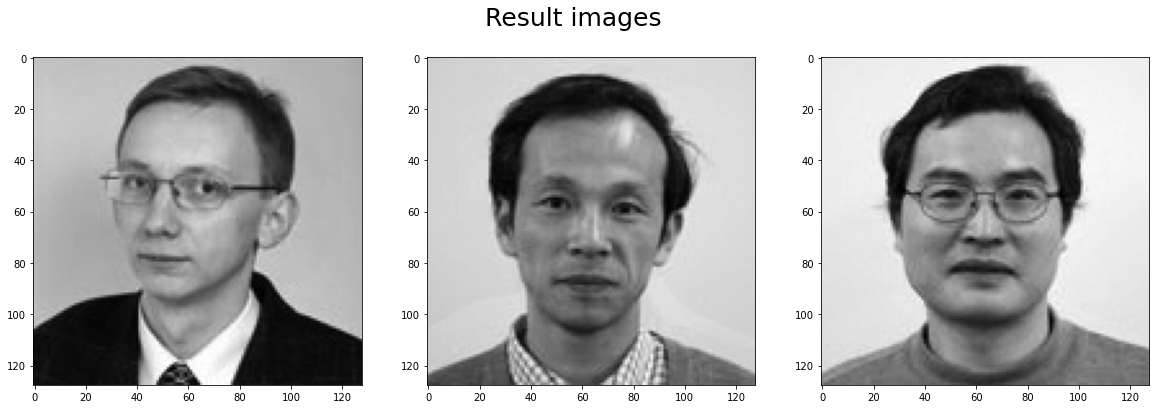

In [19]:
plt.figure(figsize=(20, 10))
for i in range(3):
    new_img = base_img[i, :].reshape(img_shape)
    plt.subplot(1, 3, i + 1)
    plt.imshow(new_img, cmap='gray')
    
plt.suptitle("Result images", y=0.8, fontsize=25)
plt.show()

Также проверим работу метода на каких-нибудь других картиночках:

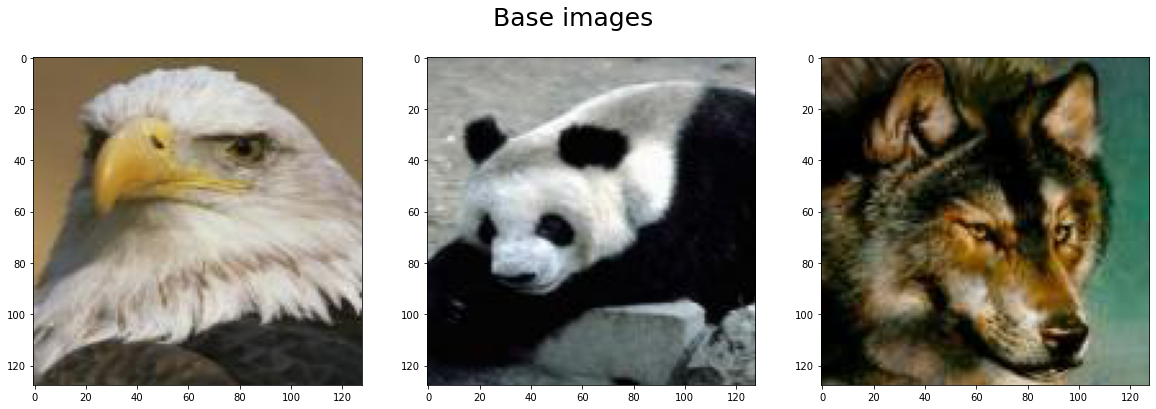

In [20]:
path2 = ['./photo/eagle.jpg', './photo/panda.jpg', './photo/wolf.jpg']
img2 = [plt.imread(path) for path in path2]

img_shape = img2[0].shape

plt.figure(figsize=(20, 10))
for i, img in enumerate(img2):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    
plt.suptitle("Base images", y=0.8, fontsize=25)
plt.show()

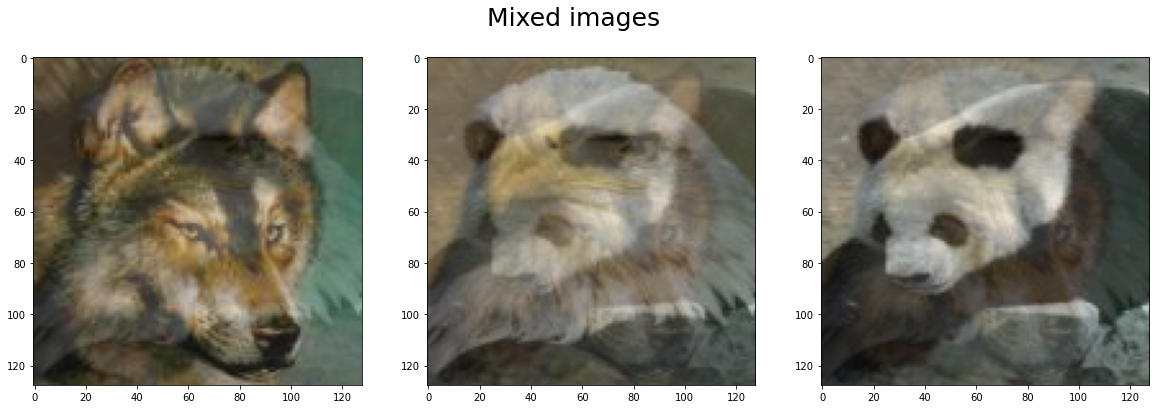

In [21]:
s_values_2 = np.array([img.flatten() for img in img2])

coeff = np.array([
    [0.3, 0.1, 0.6],
    [0.5, 0.3, 0.2],
    [0.2, 0.6, 0.2], 
])

x_values_2 = coeff @ s_values_2

plt.figure(figsize=(20, 10))
for i in range(3):
    new_img = x_values_2[i, :].reshape(img_shape)
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.round(new_img).astype(int))
    
plt.suptitle("Mixed images", y=0.8, fontsize=25)
plt.show()

In [22]:
base_img_2 = CAMNS_LP(x_values_2)

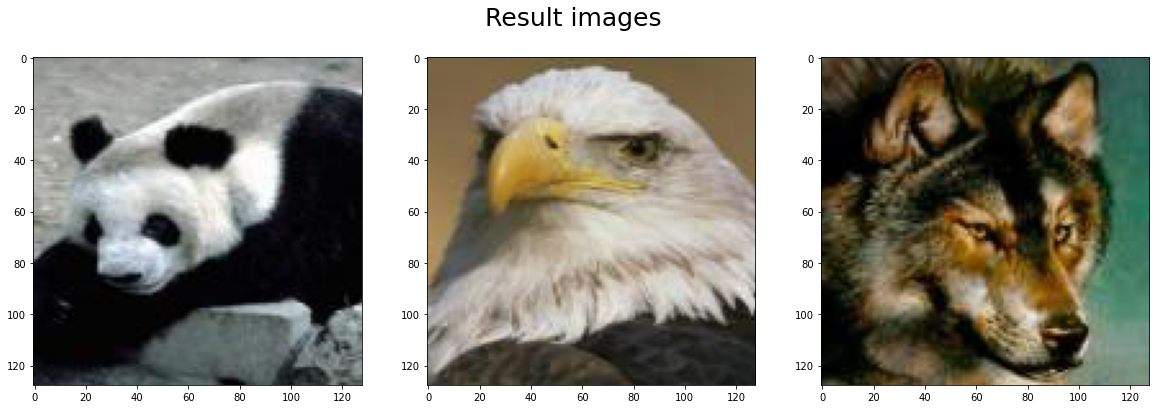

In [24]:
plt.figure(figsize=(20, 10))
for i in range(3):
    new_img = base_img_2[i, :].reshape(img_shape)
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.round(new_img).astype(int))
    
plt.suptitle("Result images", y=0.8, fontsize=25)
plt.show()

Алгоритм смог различить исходные изображения! Это победа, товарищи!